# Comparative analysis of species trees

## Summary

Compare the phylogenetic relationships and distances indicated by individual species trees.

Two metrics are used to evaluate the distance between a pair of trees:

1. **[Robinson–Foulds](https://en.wikipedia.org/wiki/Robinson%E2%80%93Foulds_metric) distance** (RF), which measures the topological discrepancy between two trees.

  - Calculated using scikit-bio's [compare_rfd](http://scikit-bio.org/docs/latest/generated/skbio.tree.TreeNode.compare_rfd.html#skbio.tree.TreeNode.compare_rfd) function.

  - For example, tree 1 has *n* clades, tree 2 has *m* clades, of which *k* clades have identical sets of descendants. Therefore absolute RF = n + m – 2k; relative RF = absolute RF / (n + m).


2. **Tip distance** (TT), which measures the correlation between phylogenetic distances (i.e., sum of branch lengths) among taxa

  - Calculated using scikit-bio's [compare_tip_distances](http://scikit-bio.org/docs/latest/generated/skbio.tree.TreeNode.compare_tip_distances.html#skbio.tree.TreeNode.compare_tip_distances) function.
  
  - TT = (1 - r) / 2, in which *r* is the Pearson correlation coefficient between the two distance matrices. Therefore the range is 0 (positively correlated) to 0.5 (unrelated) to 1 (negatively correlated).

The resulting RF or TT distance matrices are analyzed using choice of the following:

1. Heatmap.
2. Hierarchical clustering.
3. Dimensionality reduction:
  - PCoA and mMDS.
  - 2D Scatter plot or interative 3D display in Emperor.
4. Mantel test.
5. PERMANOVA test.

## Dependencies

In [1]:
from os import listdir
from os.path import join, splitext

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from matplotlib.lines import Line2D

In [4]:
from scipy.stats import ttest_ind, ttest_rel
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [5]:
from skbio.tree import TreeNode
from skbio.stats.distance import DistanceMatrix
from skbio.stats.ordination import pcoa as PCoA

In [6]:
from sklearn.manifold import MDS

In [7]:
%matplotlib inline

In [8]:
sns.set_palette('muted')

## Helpers

Prune two trees to shared taxon set

In [9]:
def nshare(tree1, tree2):
    taxa1 = tree1.subset()
    taxa2 = tree2.subset()
    return len(taxa1.intersection(taxa2))

Calculate normalized Robinson–Foulds distance

In [10]:
def rfd(tree1, tree2):
    taxa1 = tree1.subset()
    taxa2 = tree2.subset()
    if taxa1 != taxa2:
        taxa = taxa1.intersection(taxa2)
        if len(taxa) == 0:
            raise ValueError('No shared taxa found.')
        tcopy1 = tree1.shear(taxa)
        tcopy2 = tree2.shear(taxa)
        return tcopy1.compare_rfd(tcopy2, proportion=True)
    else:
        return tree1.compare_rfd(tree2, proportion=True)

Calculate "tip distance"

In [11]:
def ttd(tree1, tree2):
    if tree1 is tree2:
        return 0.0
    taxa1 = tree1.subset()
    taxa2 = tree2.subset()
    if taxa1 != taxa2:
        taxa = taxa1.intersection(taxa2)
        if len(taxa) == 0:
            raise ValueError('No shared taxa found.')
        tcopy1 = tree1.shear(taxa)
        tcopy2 = tree2.shear(taxa)
        return tcopy1.compare_tip_distances(tcopy2)
    else:
        return tree1.compare_tip_distances(tree2)

Generate an Emperor-compatible coordinates file

In [12]:
def make_emp_coods(coords):
    n, m = coords.shape 
    res = []
    res.append('Eigvals\t%d' % m)
    res.append('\t'.join(['0'] * m))
    res.append('')
    res.append('Proportion explained\t%d' % m)
    res.append('\t'.join(['0'] * m))
    res.append('')
    res.append('Species\t0\t0')
    res.append('')
    res.append('Site\t%d\t%d' % (n, m))
    for row in coords.itertuples():
        res.append('\t'.join([str(x) for x in row]))
    res.append('')
    res.append('Biplot\t0\t0')
    res.append('')
    res.append('Site constraints\t0\t0')
    return res

Read Emperor coordinates file

In [13]:
def read_emp_coords(f):
    reading = False
    loads, coords = [], []
    for line in f:
        line = line.rstrip('\r\n')
        if line.startswith('Proportion explained'):
            loads = [float(x) for x in next(f).rstrip('\r\n').split('\t')]
            continue
        if line.startswith('Site'):
            reading = True
            continue
        if reading:
            if line == '':
                break
            row = line.split('\t')
            coords.append((row[0], [float(x) for x in row[1:]]))
    return loads, coords

## Input files

In [16]:
meta = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
meta

,method,support,sites,taxa
name,,,,
astral,ASTRAL,lpp,all,all
concat.cons,CONCAT,xboot,conserved,all
concat.rand,CONCAT,xboot,random,all
concat.rpls,CONCAT,xboot,r-proteins,all
concat.fast,FastTree,alrt,all,all
concat.al1k,CONCAT,xboot,all,1k
pmsf.cons,PMSF,ufboot,conserved,1k
pmsf.rand,PMSF,ufboot,random,1k
pmsf.rpls,PMSF,ufboot,r-proteins,1k


In [23]:
ids = meta.index.tolist()

In [17]:
trees = {x: TreeNode.read('../../release/%s.nwk' % x) for x in ids}

In [24]:
for tree in ids:
    print('%s\t%s' % (tree, trees[tree].count(tips=True)))

astral	10575
concat.cons	10575
concat.rand	10575
concat.rpls	9814
concat.fast	10575
concat.al1k	1000
pmsf.cons	1000
pmsf.rand	1000
pmsf.rpls	955
gtdb	8042


In [19]:
for k, v in trees.items():
    for tree in v:
        for node in tree.traverse():
            if node.length is None:
                node.length = 0.0

## Distance calculation

### Robinson–Foulds distance

In [25]:
rfdm = DistanceMatrix.from_iterable([trees[i] for i in ids], rfd, keys=ids)
rfdm.to_data_frame().head()

,astral,concat.cons,concat.rand,concat.rpls,concat.fast,concat.al1k,pmsf.cons,pmsf.rand,pmsf.rpls,gtdb
astral,0.000000,0.312390,0.260245,0.253218,0.256512,0.328657,0.357715,0.324649,0.306401,0.185697
concat.cons,0.312390,0.000000,0.178961,0.340374,0.215869,0.296593,0.305611,0.291583,0.392445,0.276053
concat.rand,0.260245,0.178961,0.000000,0.303927,0.155872,0.289579,0.320641,0.265531,0.353620,0.235861
concat.rpls,0.253218,0.340374,0.303927,0.000000,0.309172,0.352571,0.386149,0.366212,0.229801,0.224945
concat.fast,0.256512,0.215869,0.155872,0.309172,0.000000,0.280561,0.317635,0.277555,0.365163,0.229889


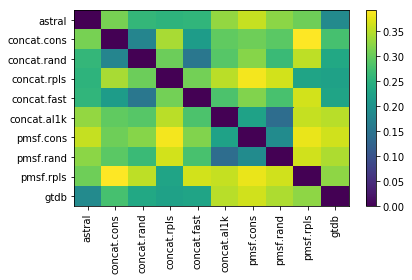

In [26]:
fig = rfdm.plot()
fig.tight_layout()
fig.savefig('rfdm.pdf', bbox_to_inches='tight')

In [27]:
rfdm.write('rf.dm')

'rf.dm'

In [49]:
rfdm_noctl = rfdm.filter([x for x in ids if x != 'gtdb'])

In [52]:
rfdm_noctl.write('rf.noctl.dm')

'rf.noctl.dm'

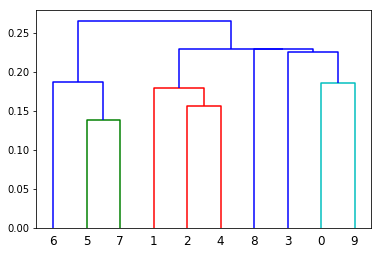

In [28]:
arr = rfdm.condensed_form()
lm = linkage(arr)
dendrogram(lm);

In [29]:
tot = TreeNode.from_linkage_matrix(lm, rfdm.ids)
print(tot.ascii_art())

                    /-pmsf.cons
          /--------|
         |         |          /-concat.al1k
         |          \--------|
         |                    \-pmsf.rand
---------|
         |                    /-concat.cons
         |          /--------|
         |         |         |          /-concat.rand
         |         |          \--------|
          \--------|                    \-concat.fast
                   |
                   |          /-pmsf.rpls
                    \--------|
                             |          /-concat.rpls
                              \--------|
                                       |          /-astral
                                        \--------|
                                                  \-gtdb


In [30]:
tot.write('rfdm.hclust.nwk')

'rfdm.hclust.nwk'

In [31]:
axes = 5

In [32]:
columns=['PC%d' % i for i in range(1, axes + 1)]

In [33]:
mds = MDS(n_components=axes, dissimilarity='precomputed', random_state=42,
          max_iter=3000, eps=1e-12, n_jobs=1)
mds.fit(rfdm.data)
mds.stress_

0.007736988269159666

In [34]:
mds = pd.DataFrame(data=mds.embedding_, index=rfdm.ids, columns=columns)
mds.head()

,PC1,PC2,PC3,PC4,PC5
astral,0.009561,0.164653,0.033619,-0.006532,-0.087234
concat.cons,-0.037014,-0.084941,0.092394,-0.051938,0.136128
concat.rand,-0.014258,0.036848,0.017949,-0.118890,0.092741
concat.rpls,-0.143501,-0.024763,0.004762,0.008653,-0.160881
concat.fast,0.058099,-0.020733,0.063163,-0.139019,-0.009976


In [35]:
mds.to_csv('rf.mds.tsv', sep='\t')

In [36]:
with open('rf.mds.coords', 'w') as f:
    for line in make_emp_coods(mds):
        f.write('%s\n' % line)

### Tip distance

In [44]:
ttdm = DistanceMatrix.from_iterable([trees[i] for i in ids[:-1]], ttd, keys=ids[:-1], validate=False)

`validate=False` because the output is slightly different due to Python float number issue when shuffling left and right.

In [45]:
ttdm.to_data_frame().head()

,cons.g,cons.r,cons.pmsf,rand.g,rand.r,rand.pmsf,rpls.g,rpls.r,rpls.pmsf,cons.full,rand.full,rpls.full,all.1k,all.ft
cons.g,0.000000,0.003365,0.011781,0.043585,0.043554,0.032458,0.122689,0.125601,0.158944,0.017259,0.067997,0.125146,0.060530,0.079152
cons.r,0.003365,0.000000,0.012108,0.045178,0.045561,0.034679,0.120442,0.123395,0.156039,0.017905,0.070206,0.123104,0.060931,0.081601
cons.pmsf,0.011781,0.012108,0.000000,0.064342,0.064565,0.040977,0.107975,0.110159,0.137176,0.024457,0.093341,0.109951,0.082017,0.101151
rand.g,0.043585,0.045178,0.064342,0.000000,0.001415,0.008655,0.173563,0.178403,0.225706,0.039027,0.020601,0.180102,0.024207,0.038239
rand.r,0.043554,0.045561,0.064565,0.001415,0.000000,0.009065,0.172770,0.177679,0.225096,0.038574,0.020244,0.179372,0.024121,0.037845


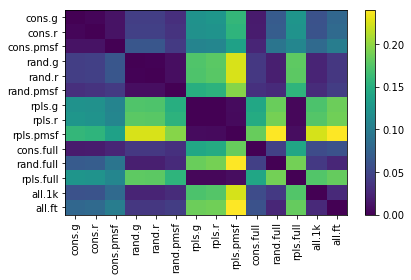

In [46]:
fig = ttdm.plot()
fig.tight_layout()
fig.savefig('ttdm.pdf', bbox_to_inches='tight')

In [47]:
ttdm.write('tt.dm')

'tt.dm'

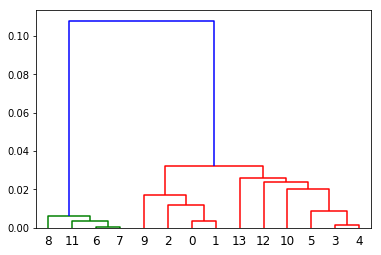

In [48]:
arr = ttdm.condensed_form()
lm = linkage(arr)
dendrogram(lm);

In [49]:
tot = TreeNode.from_linkage_matrix(lm, ttdm.ids)
print(tot.ascii_art())

                    /-rpls.pmsf
          /--------|
         |         |          /-rpls.full
         |          \--------|
         |                   |          /-rpls.g
         |                    \--------|
         |                              \-rpls.r
---------|
         |                    /-cons.full
         |          /--------|
         |         |         |          /-cons.pmsf
         |         |          \--------|
         |         |                   |          /-cons.g
          \--------|                    \--------|
                   |                              \-cons.r
                   |
                   |          /-all.ft
                    \--------|
                             |          /-all.1k
                              \--------|
                                       |          /-rand.full
                                        \--------|
                                                 |          /-rand.pmsf
                       

In [50]:
tot.write('ttdm.hclust.nwk')

'ttdm.hclust.nwk'

In [51]:
mds = MDS(n_components=axes, dissimilarity='precomputed', random_state=42,
          max_iter=3000, eps=1e-12, n_jobs=1)
mds.fit(ttdm.data)
mds.stress_

0.004684824083904768

In [52]:
mds = pd.DataFrame(data=mds.embedding_, index=ttdm.ids, columns=columns)
mds.head()

,PC1,PC2,PC3,PC4,PC5
cons.g,-0.005024,0.006392,0.015531,-0.001734,-0.008630
cons.r,-0.005321,0.006007,0.013637,-0.001174,-0.007180
cons.pmsf,-0.005050,0.009020,0.000080,0.005273,-0.009201
rand.g,-0.008093,0.002175,0.061617,-0.020258,-0.008373
rand.r,-0.007136,0.002298,0.061379,-0.020385,-0.008098


In [53]:
mds.to_csv('tt.mds.tsv', sep='\t')

In [54]:
with open('tt.mds.coords', 'w') as f:
    for line in make_emp_coods(mds):
        f.write('%s\n' % line)

## QIIME analysis

In [ ]:
%%script bash

# import a distance matrix into QIIME
qiime tools import --type DistanceMatrix --input-path rf.dm --output-path rf.qza
qiime tools import --type DistanceMatrix --input-path tt.dm --output-path tt.qza

# run PCoA
qiime diversity pcoa --i-distance-matrix rf.qza --o-pcoa rf.pcoa.qza
qiime diversity pcoa --i-distance-matrix tt.qza --o-pcoa tt.pcoa.qza

# export PCoA coordinates
qiime tools export --input-path rf.pcoa.qza --output-path .
mv ordination.txt rf.pcoa.coords
qiime tools export --input-path tt.pcoa.qza --output-path .
mv ordination.txt tt.pcoa.coords

# import mMDS coordinates into QIIME
qiime tools import --type PCoAResults --input-path rf.mds.coords --output-path rf.mds.qza
qiime tools import --type PCoAResults --input-path tt.mds.coords --output-path tt.mds.qza

# generate interactive PCoA or mMDS plot
qiime emperor plot --i-pcoa rf.pcoa.qza --m-metadata-file metadata.tsv --o-visualization rf.pcoa.qzv
qiime emperor plot --i-pcoa tt.pcoa.qza --m-metadata-file metadata.tsv --o-visualization tt.pcoa.qzv
qiime emperor plot --i-pcoa rf.mds.qza --m-metadata-file metadata.tsv --o-visualization rf.mds.qzv
qiime emperor plot --i-pcoa tt.mds.qza --m-metadata-file metadata.tsv --o-visualization tt.mds.qzv

# compare two distance matrices using the Mantel test
qiime diversity mantel --i-dm1 rf.qza --i-dm1 tt.qza

# assess separation by metadata column using the PERMANOVA test
qiime diversity beta-group-significance \
  --i-distance-matrix rf.qza \
  --m-metadata-file metadata.tsv \
  --m-metadata-column method \
  --o-visualization rf.permanova.method.qzv \
  --p-pairwise

## Distance plots

In [38]:
rfs = np.triu(rfdm.redundant_form())

In [43]:
ticks = [x + 0.5 for x in range(len(ids))]

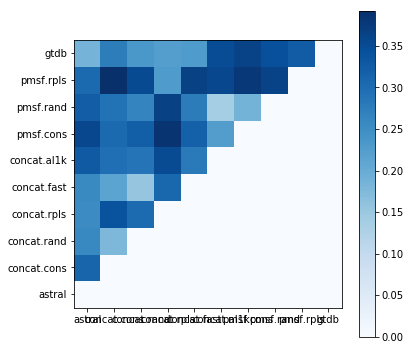

In [46]:
fig = plt.figure(figsize=(6, 6))
plt.gca().set_aspect('equal')
plt.pcolormesh(rfs.T, cmap='Blues')
plt.xticks(ticks, labels=ids)
plt.yticks(ticks, labels=ids)
plt.colorbar();

In [47]:
fig.tight_layout()
fig.savefig('rf.heat.pdf', bbox_inches='tight')

### PCoAs

Read data

In [326]:
df = pd.read_csv(meta_fp, sep='\t', index_col=0)
df.head()

,loci,site,model,taxa,tool
#SampleID,,,,,
cons.g,glob,cons,g,1k,iqtree
cons.r,glob,cons,r,1k,iqtree
cons.pmsf,glob,cons,pmsf,1k,iqtree
rand.g,glob,rand,g,1k,iqtree
rand.r,glob,rand,r,1k,iqtree


In [327]:
with open('rf.pcoa.coords', 'r') as f:
    rf_loads, rf_coords = read_emp_coords(f)

In [328]:
dfrf = pd.DataFrame(dict(rf_coords)).head(3).T
dfrf.columns = ['rf_pcoa1', 'rf_pcoa2', 'rf_pcoa3']

In [329]:
df = pd.concat([df, dfrf], axis=1)

In [330]:
with open('tt.pcoa.coords', 'r') as f:
    tt_loads, tt_coords = read_emp_coords(f)

In [331]:
dftt = pd.DataFrame(dict(tt_coords)).head(3).T
dftt.columns = ['tt_pcoa1', 'tt_pcoa2', 'tt_pcoa3']

In [332]:
df = pd.concat([df, dftt], axis=1, sort=False)

In [333]:
df.head()

,loci,site,model,taxa,tool,rf_pcoa1,rf_pcoa2,rf_pcoa3,tt_pcoa1,tt_pcoa2,tt_pcoa3
cons.g,glob,cons,g,1k,iqtree,-0.134548,-0.086041,0.085994,-0.014405,0.015797,0.000256
cons.r,glob,cons,r,1k,iqtree,-0.142440,-0.070604,0.095630,-0.012164,0.016145,-0.001151
cons.pmsf,glob,cons,pmsf,1k,iqtree,-0.118920,-0.074918,0.035050,0.004261,0.029172,0.000986
rand.g,glob,rand,g,1k,iqtree,-0.123182,-0.044060,-0.064860,-0.071508,0.009869,-0.006953
rand.r,glob,rand,r,1k,iqtree,-0.124673,-0.047599,-0.066231,-0.070826,0.008662,-0.006848


RF distance

In [378]:
sizes={'1k': 49, 'all': 81}
markers={'all': 'o', 'cons': 'D', 'rand': 's', 'rpls': 'X'}

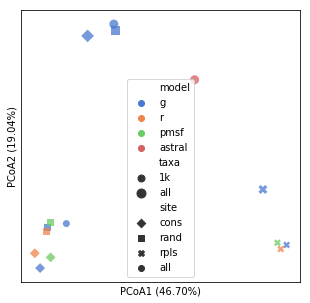

In [379]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='rf_pcoa1', y='rf_pcoa2', hue='model', alpha=0.75, linewidth=0,
                style='site', markers=markers, size='taxa', sizes=sizes, data=df, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCoA1 (%.2f%%)' % (rf_loads[0] * 100))
ax.set_ylabel('PCoA2 (%.2f%%)' % (rf_loads[1] * 100));

In [380]:
fig.tight_layout()
fig.savefig('rf.pcoa.pdf', bbox_inches='tight')

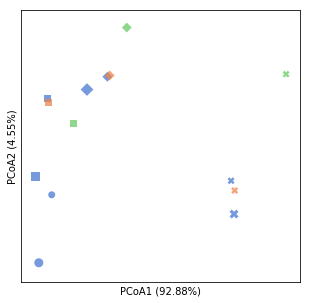

In [382]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='tt_pcoa1', y='tt_pcoa2', hue='model', alpha=0.75, linewidth=0,
                style='site', markers=markers, size='taxa', sizes=sizes, legend=False, data=df, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PCoA1 (%.2f%%)' % (tt_loads[0] * 100))
ax.set_ylabel('PCoA2 (%.2f%%)' % (tt_loads[1] * 100));

In [383]:
fig.tight_layout()
fig.savefig('tt.pcoa.pdf', bbox_inches='tight')